In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Classification Tree

In [13]:
df = pd.read_csv('loans.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516 entries, 0 to 9515
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      9516 non-null   int64  
 1   installment  9516 non-null   int64  
 2   log_income   9516 non-null   float64
 3   fico_score   9516 non-null   int64  
 4   rev_balance  9516 non-null   float64
 5   inquiries    9516 non-null   int64  
 6   records      9516 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 520.5 KB


In [14]:
df.head()

,default,installment,log_income,fico_score,rev_balance,inquiries,records
0,0,829,4.93,737,28.85,0,0
1,0,228,4.81,707,33.62,0,0
2,0,367,4.51,682,3.51,1,0
3,0,162,4.93,712,33.67,1,0
4,0,103,4.91,667,4.74,0,0


In [15]:
df.default.value_counts(normalize=True)

default
0    0.840164
1    0.159836
Name: proportion, dtype: float64

Training and Test Datasets

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [17]:
X = df_train.copy()
X_test = df_test.copy()
y = X.pop('default')
y_test = X_test.pop('default')

Logistic Regression

In [18]:
from statsmodels.formula.api import logit

formula="default ~ installment + log_income + fico_score + rev_balance + inquiries + records"
est = logit(formula=formula, data=df_train).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.415078
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 6661
Model:                          Logit   Df Residuals:                     6654
Method:                           MLE   Df Model:                            6
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                 0.05338
Time:                        14:59:13   Log-Likelihood:                -2764.8
converged:                       True   LL-Null:                       -2920.7
Covariance Type:            nonrobust   LLR p-value:                 2.415e-64
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.7634      0.994      9.824      0.000       7.816      11.711
installment     0.0013    

Helper Functions

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


def profit(y, y_pred, cutoff=0.5, verbose=False):
  '''
  Given a probability cutoff, predicted probabilities, and actual y values,
  calculates the profit per applicant
  '''
  will_default = np.where(y_pred >= cutoff, 1, 0)
  cm = confusion_matrix(y, will_default)
  if verbose:
    ConfusionMatrixDisplay.from_predictions(
        y,
        will_default,
        display_labels = ['No Default', 'Default']
        )
  cm_profit = 1000*cm[0,0]-5000*cm[1,0]
  return cm_profit/len(y)

def profit_table(y, y_pred, cutoffs=np.arange(0,1.01,0.1)):
  '''
  Given predicted probabilities, actual y values, and a set of cutoffs,
  calculates the profit per applicant for each cutoff
  and returns it in a two-column dataframe
  '''
  return pd.DataFrame({'cutoff': cutoffs,
                       'profit': [profit(y, y_pred, cutoff) for cutoff in cutoffs]})

def best_profit_and_cutoff(y, y_pred):
  '''
  Given predicted probabilities and actual y values, returns the optimal
  cutoff and optimal profit per applicant
  '''
  pf = profit_table(y, y_pred)
  idx = pf.profit.idxmax()
  return pf.loc[idx]

Classification Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [21]:
def viz_tree(tree, font=12, figsize=(16,10)):
    ''''
    Dibuja un arbol de clasificación
    '''
    plt.figure(figsize=figsize)
    plot_tree(tree, feature_names=X.columns, filled=True, fontsize=font)

In [23]:
tree = DecisionTreeClassifier(random_state=42)

In [24]:
tree.fit(X,y)

DecisionTreeClassifier(random_state=42)

In [25]:
y_pred = tree.predict_proba(X_test)[:,1]
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,74.255692
2,0.2,74.255692
3,0.3,74.255692
4,0.4,74.255692
5,0.5,74.255692
6,0.6,74.255692
7,0.7,74.255692
8,0.8,74.255692
9,0.9,74.255692


In [26]:
y_pred = est.predict(X_test)
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,152.014011
2,0.2,153.415061
3,0.3,113.835377
4,0.4,57.793345
5,0.5,42.732049
6,0.6,32.574431
7,0.7,32.924694
8,0.8,32.924694
9,0.9,33.274956


In [27]:
tree.tree_.max_depth, tree.tree_.node_count

(35, 2515)

Cost Complexity Prunning

In [28]:
tree = DecisionTreeClassifier(random_state=42)

In [29]:
path = tree.cost_complexity_pruning_path(X,y)

In [33]:
alphas = path.ccp_alphas
len(alphas)

436

In [31]:
trees = []
for alpha in alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    tree.fit(X,y)
    trees.append(tree)

In [35]:
print(f"This process generated {len(trees)} trees.")

This process generated 436 trees.


In [36]:
def all_trees_profits_cutoffs(X,y):
  max_profit = []
  best_cutoff = []
  for tree in trees:
    y_pred = tree.predict_proba(X)[:,1]
    pf = best_profit_and_cutoff(y, y_pred)
    max_profit.append(pf['profit'])
    best_cutoff.append(pf['cutoff'])
  return max_profit, best_cutoff

In [37]:
train_profits, train_cutoffs = all_trees_profits_cutoffs(X,y)
test_profits, test_cutoffs = all_trees_profits_cutoffs(X_test,y_test)

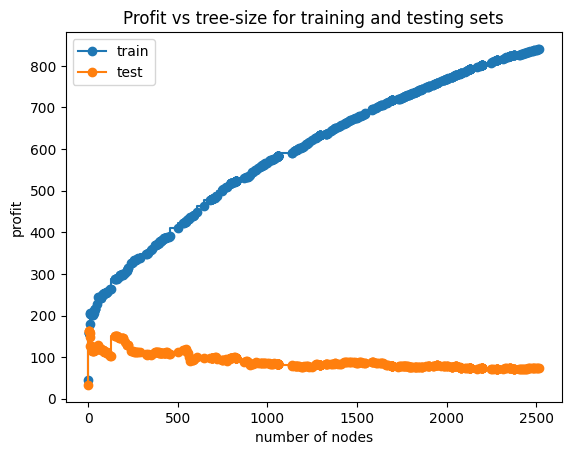

In [38]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html


node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]


fig, ax = plt.subplots()
ax.set_xlabel("number of nodes")
ax.set_ylabel("profit")
ax.set_title("Profit vs tree-size for training and testing sets")
ax.plot(node_counts, train_profits, marker="o", label="train", drawstyle="steps-post")
ax.plot(node_counts, test_profits, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [39]:
opt_idx = np.argmax(test_profits)

print(f"Profit of max-profit tree = ${max(test_profits):.2f}")
print(f"Size of max-profit tree = {node_counts[opt_idx]} nodes")
print(f"Optimal cutoff for chosen tree = {test_cutoffs[opt_idx]:.2f}")

Profit of max-profit tree = $161.82
Size of max-profit tree = 7 nodes
Optimal cutoff for chosen tree = 0.20


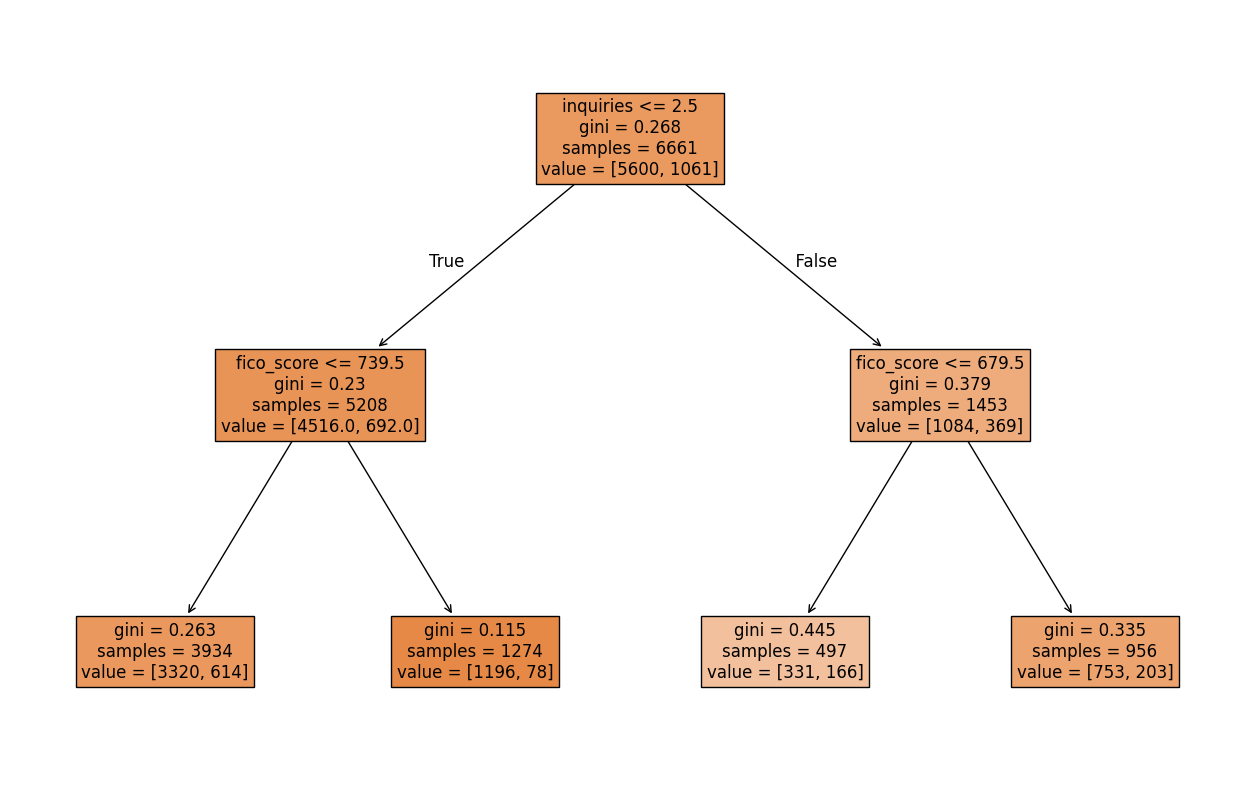

In [40]:
tree = trees[opt_idx]
viz_tree(tree)